In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

In [2]:
## Importing the Dataset and Sampling 1 Lakh Rows randomly for training.
#This is the total number of records (or rows) in the dataset that you are working with.
rows = 40428967
#This is the number of records you want to sample from the dataset
sample_size = 320000
skip_values = sorted(random.sample(range(1, rows), rows - sample_size))

data_train = pd.read_csv("/kaggle/input/assignment1b-2/train.csv",skiprows=skip_values)
data_train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10015405794859644629,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,100084,79
1,10028663841911511440,1,14102100,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,19016,300,250,2162,2,39,-1,33


In [6]:
#The code is effectively capping the outliers in the specified columns (C15, C16, C19, C21) at the 98th percentile value, but only if this percentile is less than half of the column’s maximum value. This approach helps in mitigating the effect of extreme outliers without removing them from the dataset entirely.
import numpy as np
# Assuming 'train' is a pandas DataFrame
for col in ['C15', 'C16', 'C19', 'C21']:
    percentiles = data_train[col].quantile(0.98)
    if percentiles < 0.5 * data_train[col].max():
        data_train[col] = np.where(data_train[col] >= percentiles, percentiles, data_train[col])

In [7]:
### Defining numerical and categorical variables for a better classification model.
numerical = []
categorical = []

for col in (data_train.columns):
    if data_train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


click
0    0.831106
1    0.168894
Name: proportion, dtype: float64




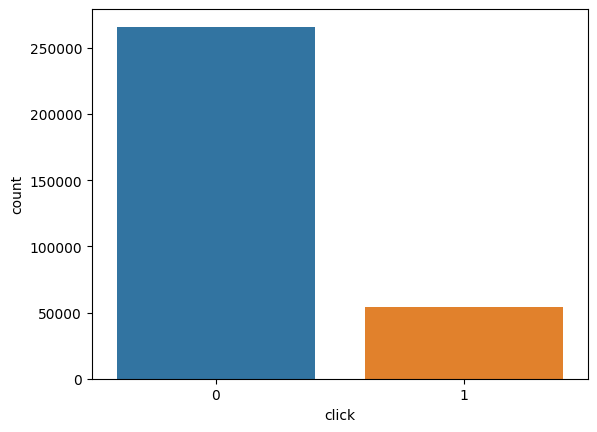

In [10]:
#Ploting the Graph
print(data_train.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=data_train)
plt.show()

In [11]:
#Removing the columns 
data_train.drop(['hour','C20'], axis=1, inplace=True)
data_train.columns

Index(['id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21'],
      dtype='object')

In [12]:
data_train.drop(['id'], axis = 1, inplace = True) 
data_train.rename(columns={'click': 'y'},
          inplace=True, errors='raise')

data_train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21'],
      dtype='object')

In [13]:
#this code samples 10% of the data from data_train, separates the features into X, and assigns the target variable to y
sampled_data = data_train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

y
0    0.831106
1    0.168894
Name: proportion, dtype: float64




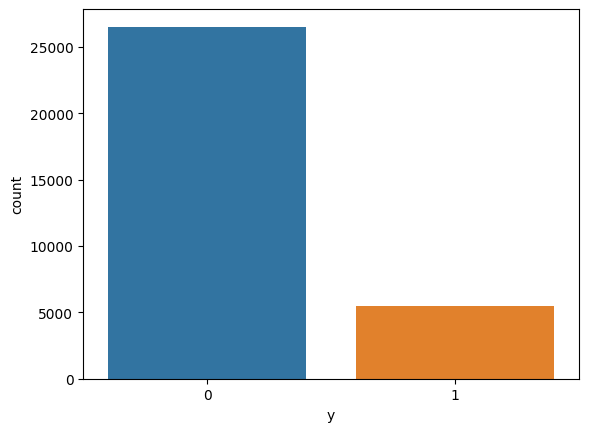

In [15]:
# After taking the sample of data, still the ratio of output remains same.

print(data_train.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

In [16]:
# This code applies target encoding to the categorical features in X based on the target variable y
import category_encoders as ce
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
115896,1005,0,0.199847,0.199847,0.201983,0.199445,0.196270,0.200154,0.174327,0.148643,0.233082,1,0,20108,320.0,50.0,2299,2,1319,52
287629,1005,0,0.119584,0.123582,0.129839,0.017004,0.021234,0.105069,0.174327,0.148643,0.017143,1,3,21191,320.0,50.0,2424,0,161,71


Original dataset shape  Counter({0: 26532, 1: 5468})
Resampled dataset shape Counter({0: 26532, 1: 26532})


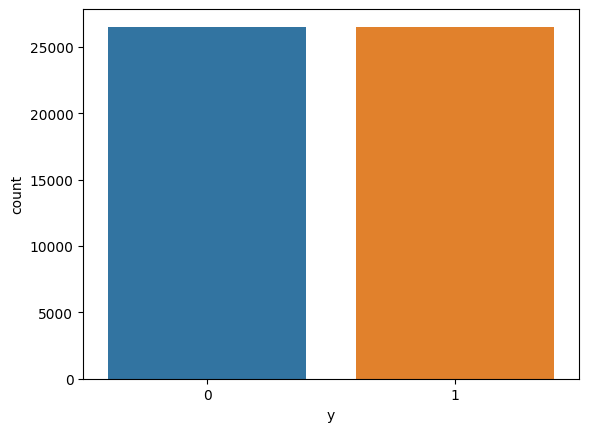

In [17]:
### Since the data is imbalanced, using random oversampling for balancing
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(x=y_new)
plt.show()

In [18]:
x_new.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
0,1005,0,0.199847,0.199847,0.201983,0.199445,0.196270,0.200154,0.174327,0.148643,0.233082,1,0,20108,320.0,50.0,2299,2,1319,52
1,1005,0,0.119584,0.123582,0.129839,0.017004,0.021234,0.105069,0.174327,0.148643,0.017143,1,3,21191,320.0,50.0,2424,0,161,71


In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify=y_new, test_size=0.2, random_state= 42)

In [20]:
# this code scales the features in the X_train DataFrame to a range between 0 and 1 using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
29229,0.363636,0.0,0.330404,0.317082,0.637702,0.499139,0.590110,0.642727,0.212834,0.373404,0.498799,0.2,0.0,0.647807,1.000000,0.065421,0.608926,0.000000,0.001107,0.307087
11393,0.363636,0.0,0.197696,0.188476,0.390503,0.443987,0.529012,0.114325,0.076333,0.373404,0.327438,0.2,0.0,0.182202,1.000000,0.065421,0.117625,0.666667,0.003322,0.122047
11997,0.090909,0.0,0.304477,0.290639,0.390503,0.499139,0.590110,0.642727,0.767799,0.914195,0.587286,0.0,0.0,0.252894,0.807692,0.065421,0.163389,1.000000,0.003322,0.086614
11844,0.363636,0.0,0.197696,0.188476,0.390503,0.443987,0.529012,0.114325,0.212834,0.373404,0.591923,0.2,0.0,0.182202,1.000000,0.065421,0.117625,0.666667,0.003322,0.122047
5402,0.363636,0.0,0.330404,0.317082,0.637702,0.499139,0.590110,0.642727,0.212834,0.373404,0.452945,0.2,0.0,0.647722,1.000000,0.065421,0.608926,0.000000,0.001107,0.307087


In [22]:
# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)# Ensure y_train is a column vector

In [23]:
# this code defines a logistic regression model in PyTorch as a subclass of nn.Module. It consists of a single linear layer followed by a sigmoid activation function
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [24]:
# this code initializes a logistic regression model for binary classification, defines the loss function to evaluate the model's predictions, and sets up the SGD optimizer for adjusting the model parameters during training.
import torch.optim as optim

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = LogisticRegression(input_dim)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [25]:
# this code defines the training loop for a neural network model using PyTorch, iterating through the training dataset for a specified number of epochs. During each epoch, it performs a forward pass to obtain predictions, calculates the loss, computes gradients through backpropagation, and updates the model's parameters.
num_epochs = 10000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.6897
Epoch [200/10000], Loss: 0.6740
Epoch [300/10000], Loss: 0.6592
Epoch [400/10000], Loss: 0.6450
Epoch [500/10000], Loss: 0.6316
Epoch [600/10000], Loss: 0.6187
Epoch [700/10000], Loss: 0.6065
Epoch [800/10000], Loss: 0.5947
Epoch [900/10000], Loss: 0.5835
Epoch [1000/10000], Loss: 0.5728
Epoch [1100/10000], Loss: 0.5625
Epoch [1200/10000], Loss: 0.5527
Epoch [1300/10000], Loss: 0.5432
Epoch [1400/10000], Loss: 0.5342
Epoch [1500/10000], Loss: 0.5255
Epoch [1600/10000], Loss: 0.5171
Epoch [1700/10000], Loss: 0.5090
Epoch [1800/10000], Loss: 0.5013
Epoch [1900/10000], Loss: 0.4938
Epoch [2000/10000], Loss: 0.4866
Epoch [2100/10000], Loss: 0.4797
Epoch [2200/10000], Loss: 0.4730
Epoch [2300/10000], Loss: 0.4665
Epoch [2400/10000], Loss: 0.4602
Epoch [2500/10000], Loss: 0.4542
Epoch [2600/10000], Loss: 0.4483
Epoch [2700/10000], Loss: 0.4427
Epoch [2800/10000], Loss: 0.4372
Epoch [2900/10000], Loss: 0.4319
Epoch [3000/10000], Loss: 0.4268
Epoch [3100/10000],

In [26]:
# After training the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(X_train_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_train_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

Accuracy: 0.9492


In [27]:
# Convert X_train and y_train to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Ensure y_train is a column vector

In [28]:
# After training the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(X_test_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

Accuracy: 0.5000


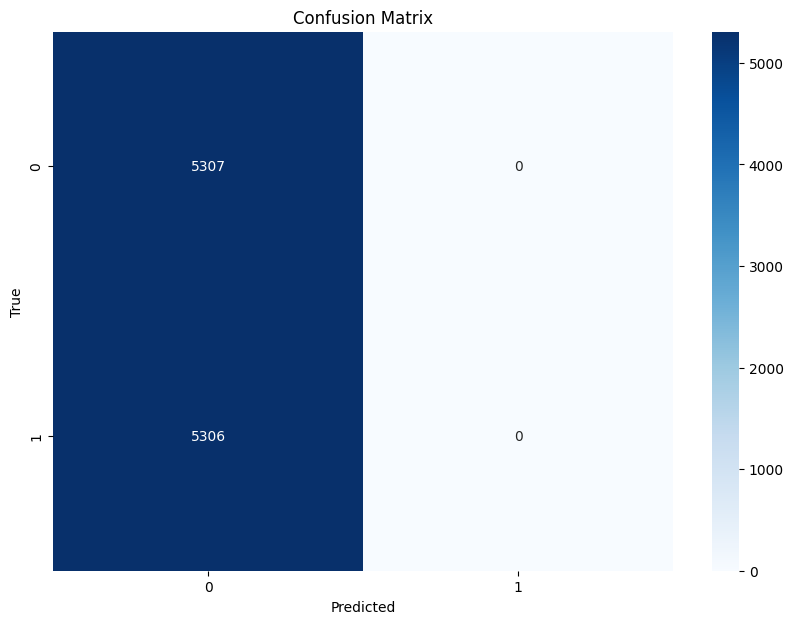

In [29]:
# Overall, this code evaluates the performance of a classification model by generating predictions on a test dataset, constructing a confusion matrix based on the predicted and true labels, and visualizing the results with a heatmap.
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_test_tensor and y_test_tensor are your test data and labels
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

# Convert tensors to numpy arrays if needed
y_pred = predicted.numpy().astype(int)
y_true = y_test_tensor.numpy().astype(int)

# Get the number of classes
num_classes = len(np.unique(y_true))

# Initialize the confusion matrix
cm = np.zeros((num_classes, num_classes), dtype=int)

# Fill the confusion matrix
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

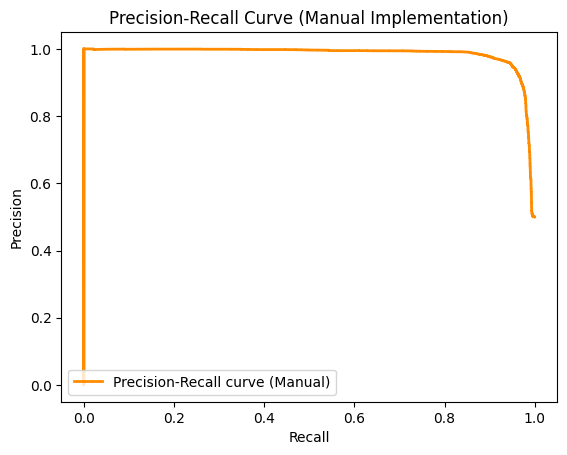

In [30]:
# Making precision-recall function and ploting the same 
def precision_recall_manual(y_true, y_scores):
    sorted_indices = np.argsort(-y_scores)
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    tp = 0 
    fp = 0  
    fn = sum(y_true) 
    
    precision_vals = []
    recall_vals = []
    prev_score = -1
    
    for i in range(len(y_scores_sorted)):
        if y_scores_sorted[i] != prev_score:  
            prev_score = y_scores_sorted[i]
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision_vals.append(precision)
            recall_vals.append(recall)
        if y_true_sorted[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
    precision_vals = [1] + precision_vals
    recall_vals = [0] + recall_vals
    
    return np.array(precision_vals), np.array(recall_vals)

with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(X_train_tensor).numpy().flatten()  # Ensure outputs is 1D numpy array
    y_true = y_train_tensor.numpy().flatten()  # Ensure y_true is 1D numpy array

precision, recall = precision_recall_manual(y_true, outputs)

# plotting the graph using the above calculated values
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (Manual)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Manual Implementation)')
plt.legend(loc="lower left")
plt.show()
